In [ ]:
"""Dataset link:
https://www.kaggle.com/kmader/skin-cancer-mnist-ham10000
Data description: 
https://arxiv.org/ftp/arxiv/papers/1803/1803.10417.pdf

The 7 classes of skin cancer lesions included in this dataset are:
Melanocytic nevi (nv)
Melanoma (mel)
Benign keratosis-like lesions (bkl)
Basal cell carcinoma (bcc) 
Actinic keratoses (akiec)
Vascular lesions (vas)
Dermatofibroma (df)
"""

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

In [17]:
np.random.seed(42)
from sklearn.metrics import confusion_matrix

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder

In [7]:
skin_df = pd.read_csv('D:/HAM10000/HAM10000_metadata.csv')
SIZE=32

In [8]:
# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
3697  HAM_0005218  ISIC_0028939   nv  follow_up  55.0  female   
7213  HAM_0007444  ISIC_0033989   nv      histo  50.0  female   
310   HAM_0002839  ISIC_0032280  bkl      histo  60.0  female   
4438  HAM_0005070  ISIC_0030863   nv  follow_up  55.0  female   
6087  HAM_0005969  ISIC_0028257   nv  follow_up  35.0    male   
3586  HAM_0001464  ISIC_0028319   nv  follow_up  70.0    male   
3733  HAM_0003513  ISIC_0030743   nv  follow_up  60.0    male   
718   HAM_0001359  ISIC_0028628  bkl      histo  75.0    male   
2090  HAM_0006006  ISIC_0028847  mel      histo  75.0    male   
3417  HAM_0002741  ISIC_0027939   nv  follow_up  45.0  female   

         localization  label  
3697  lower extremity      5  
7213  lower extremity      5  
310   lower extremity      2  
4438            trunk      5  
6087          abdomen      5  
3586            trunk      5  
3733  upper extr

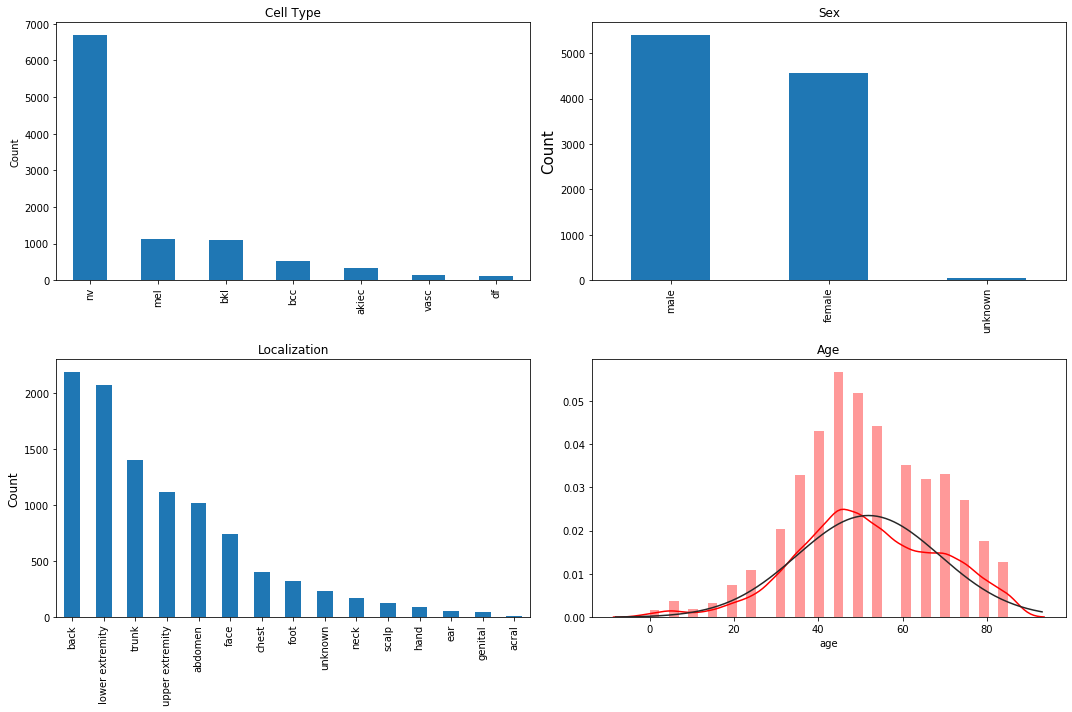

In [9]:
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [10]:
# Distribution of data into various classes 
from sklearn.utils import resample
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [11]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

#Now time to read images based on image ID from the CSV file
#This is the safest way to read images as it ensures the right image is read for the right ID
print(skin_df_balanced['label'].value_counts())


5    500
3    500
1    500
6    500
4    500
2    500
0    500
Name: label, dtype: int64


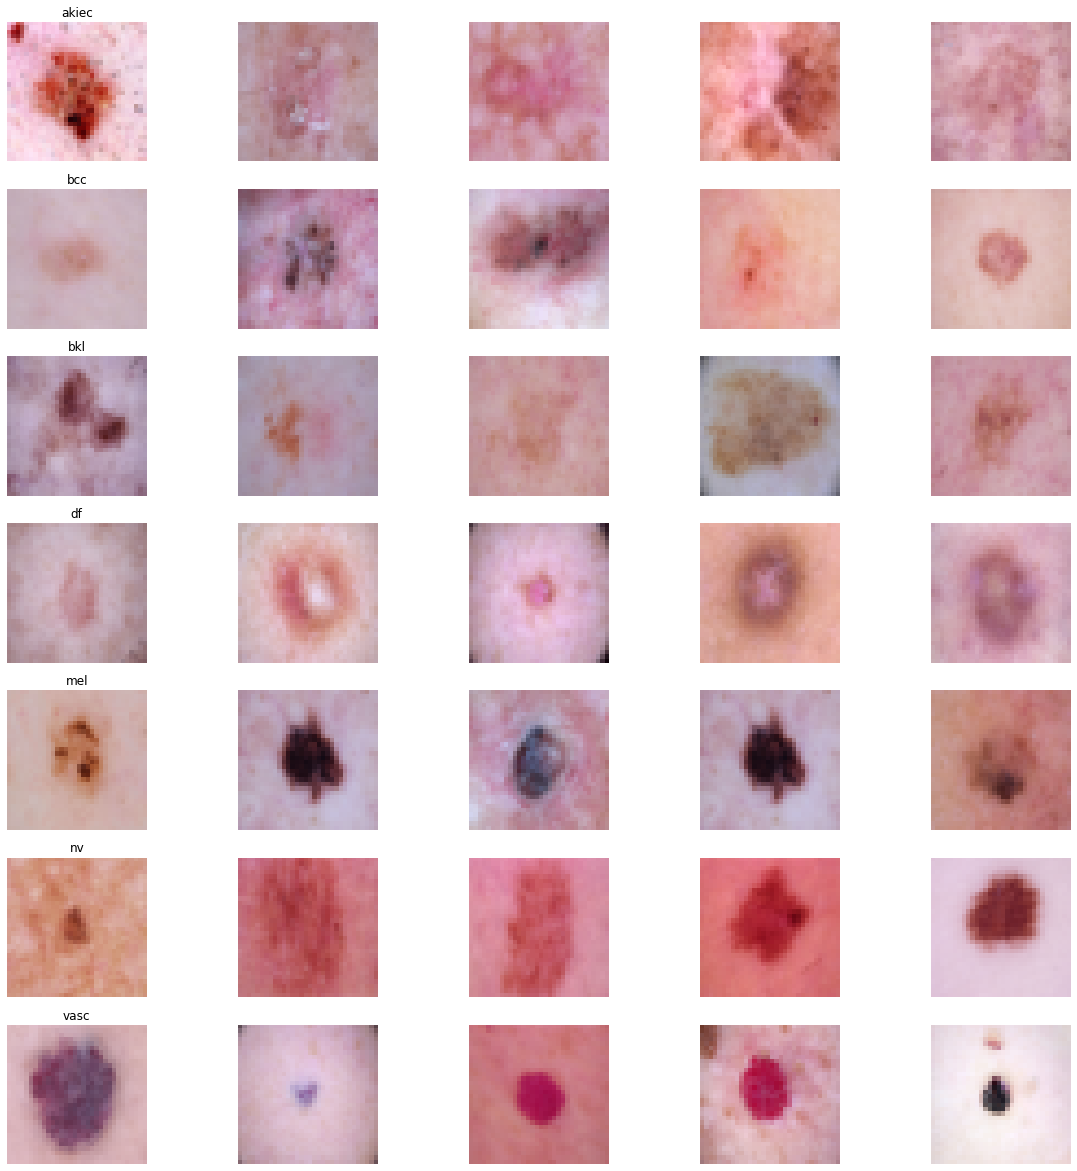

In [14]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('D:/HAM10000/', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))


n_samples = 5  

# Plot
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [15]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label']  #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)

#Define the model.
#I've used autokeras to find out the best model for this problem.
#You can also load pretrained networks such as mobilenet or VGG16

num_classes = 7

In [18]:
model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 256)       7168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 128)       295040    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)        

In [19]:
batch_size = 16 
epochs = 75

history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(x_test, y_test),
    verbose=2)

score = model.evaluate(x_test, y_test)
print('Test accuracy:', score[1])


Train on 2625 samples, validate on 875 samples
Epoch 1/75
 - 17s - loss: 1.8874 - acc: 0.2050 - val_loss: 1.9540 - val_acc: 0.1771
Epoch 2/75
 - 13s - loss: 1.6796 - acc: 0.3162 - val_loss: 1.6077 - val_acc: 0.3109
Epoch 3/75
 - 13s - loss: 1.5123 - acc: 0.3813 - val_loss: 1.5075 - val_acc: 0.3749
Epoch 4/75
 - 13s - loss: 1.4665 - acc: 0.4038 - val_loss: 1.4677 - val_acc: 0.3829
Epoch 5/75
 - 13s - loss: 1.4530 - acc: 0.4122 - val_loss: 1.3821 - val_acc: 0.4286
Epoch 6/75
 - 13s - loss: 1.3797 - acc: 0.4476 - val_loss: 1.3966 - val_acc: 0.4286
Epoch 7/75
 - 13s - loss: 1.3459 - acc: 0.4701 - val_loss: 1.3332 - val_acc: 0.4503
Epoch 8/75
 - 13s - loss: 1.3373 - acc: 0.4838 - val_loss: 1.3093 - val_acc: 0.4789
Epoch 9/75
 - 13s - loss: 1.2660 - acc: 0.5055 - val_loss: 1.2800 - val_acc: 0.4869
Epoch 10/75
 - 13s - loss: 1.2640 - acc: 0.5021 - val_loss: 1.2631 - val_acc: 0.4891
Epoch 11/75
 - 13s - loss: 1.2100 - acc: 0.5295 - val_loss: 1.2322 - val_acc: 0.5017
Epoch 12/75
 - 13s - loss:

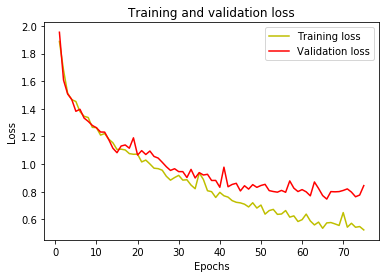

In [20]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

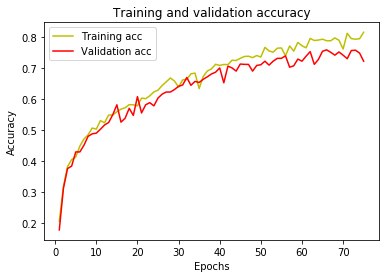

In [21]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Text(25.5, 0.5, 'Fraction of incorrect predictions')

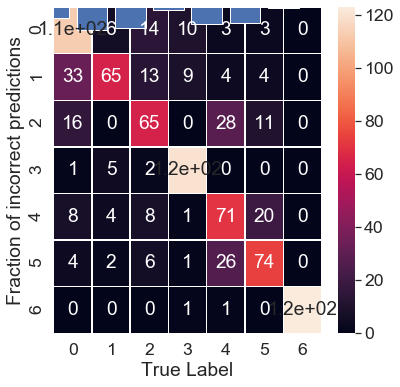

In [25]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

#Print confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)


#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')


In [26]:
model.save('skin.h5')

model.save_weights('skin_weights_final.h5')

In [30]:

def test_image(path):
    img = image.load_img(path,target_size = (32,32))
    x = image.img_to_array(img)
    x = x/255.
    return np.expand_dims(x,axis = 0)

The detected disease is [4]


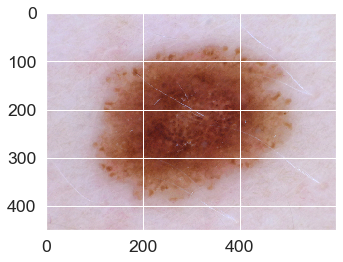

In [33]:
path = 'D:/HAM10000/HAM10000_images_part_1/ISIC_0024317.jpg'
from tensorflow.keras.preprocessing import image
result = model.predict_classes(test_image(path))
disease = image.load_img(path)
plt.imshow(disease)
print(f"The detected disease is {result}")